In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from statistics import mean
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
## read csv file
df = pd.read_csv("cereal_Kellogg_byMonth.csv", index_col = 0)
df.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,MONTH,YEAR
1331,2009-01-14,367.0,3800031829,14.0,11.0,3.0,43.96,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1332,2009-01-21,367.0,3800031829,17.0,13.0,6.0,53.38,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1333,2009-01-28,367.0,3800031829,23.0,19.0,8.0,72.22,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,1,2009
1334,2009-02-04,367.0,3800031829,25.0,23.0,10.0,78.50,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,2,2009
1335,2009-02-11,367.0,3800031829,23.0,19.0,11.0,72.22,3.14,3.14,0.0,...,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051,2,2009


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35832 entries, 1331 to 169279
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   WEEK_END_DATE            35832 non-null  object 
 1   STORE_NUM                35832 non-null  float64
 2   UPC                      35832 non-null  int64  
 3   UNITS                    35832 non-null  float64
 4   VISITS                   35832 non-null  float64
 5   HHS                      35832 non-null  float64
 6   SPEND                    35832 non-null  float64
 7   PRICE                    35832 non-null  float64
 8   BASE_PRICE               35830 non-null  float64
 9   FEATURE                  35832 non-null  float64
 10  DISPLAY                  35832 non-null  float64
 11  TPR_ONLY                 35832 non-null  float64
 12  DESCRIPTION              35832 non-null  object 
 13  MANUFACTURER             35832 non-null  object 
 14  CATEGORY          

In [4]:
## Change data dtypes
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "PRODUCT_SIZE",
       "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME", "MONTH", "YEAR"]
numeric = ["UNITS", "VISITS", "HHS", "SPEND", "PRICE", "BASE_PRICE", "PARKING_SPACE_QTY", "SALES_AREA_SIZE_NUM", "AVG_WEEKLY_BASKETS"]

## Fill missing values in PARKING_SPACE_QTY column with median of that column
## there are extreme high and low values so it's not an good idea to take the mean.
medPSQ = df.PARKING_SPACE_QTY.median()
df.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)

df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])
df[cat] = df[cat].astype("category")

In [5]:
df.groupby("SUB_CATEGORY")[["BASE_PRICE", "PRICE", "UNITS"]].mean()

,BASE_PRICE,PRICE,UNITS
SUB_CATEGORY,,,
ALL FAMILY CEREAL,3.273618,3.164362,33.303007
KIDS CEREAL,3.094547,2.908529,42.817327


In [6]:
## Split dataset by 'SUB_CATEGOTY'
## We'll be focusing on analyzing by these two sub-categories

df_family = df[df.SUB_CATEGORY == 'ALL FAMILY CEREAL']
df_family_scaled = df_family.copy()
df_family_scaled[numeric] = (df_family_scaled[numeric] - df_family_scaled[numeric].mean()) / df_family_scaled[numeric].std()

df_kids = df[df.SUB_CATEGORY == 'KIDS CEREAL']
df_kids_scaled = df_kids.copy()
df_kids_scaled[numeric] = (df_kids_scaled[numeric] - df_kids_scaled[numeric].mean()) / df_kids_scaled[numeric].std()

print(df_family_scaled.shape)
print(df_kids_scaled.shape)

(11904, 28)
(23928, 28)


In [15]:
#df_family.to_csv("cereal_Kellogg_family.csv")
#df_family_scaled.to_csv("cereal_Kellogg_family_scaled.csv")

### Regression Model_Family Cereal

In [373]:
## Split data into train and test

rvar = "UNITS"
evar = ['PRICE', 'DISPLAY', 'FEATURE', 'ADDRESS_STATE_PROV_CODE', 'AVG_WEEKLY_BASKETS', 'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']

X = df_family_scaled[evar].copy()
y = df_family_scaled[rvar]

X_train = X[df_family_scaled.WEEK_END_DATE <= '2010-12-31']
y_train = df_family_scaled.loc[df_family_scaled.WEEK_END_DATE <= '2010-12-31', 'UNITS']
X_test = X[df_family_scaled.WEEK_END_DATE > '2010-12-31']
y_test = df_family_scaled.loc[df_family_scaled.WEEK_END_DATE > '2010-12-31', 'UNITS']

In [374]:
## Create regression model using training dataset

reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + ADDRESS_STATE_PROV_CODE + AVG_WEEKLY_BASKETS + SEG_VALUE_NAME + PARKING_SPACE_QTY + SALES_AREA_SIZE_NUM', 
              data = df_family_scaled.query("WEEK_END_DATE <= '2010-12-31'"))
reg_model = reg.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  UNITS   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1090.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:22:26   Log-Likelihood:                -7110.4
No. Observations:                7825   AIC:                         1.424e+04
Df Residuals:                    7813   BIC:                         1.433e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

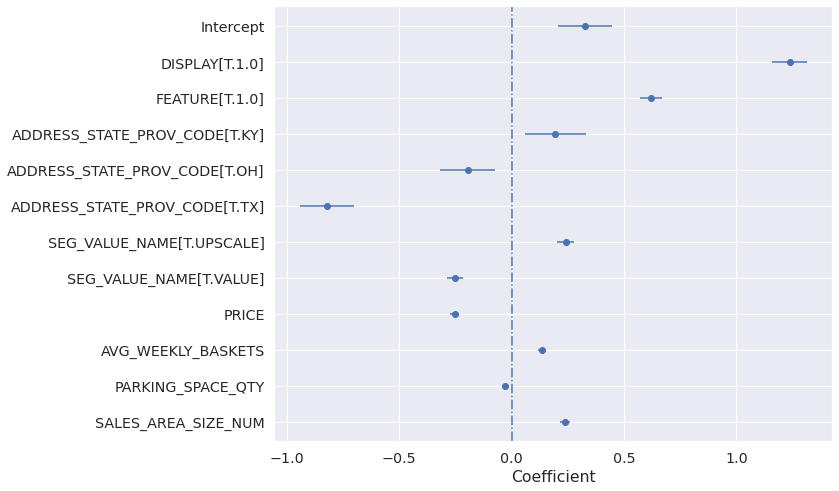

In [375]:
plt.rcParams["figure.figsize"] = [10,8]
sns.set(font_scale=1.3)
fig = rsm.coef_plot(reg_model, intercept = True)

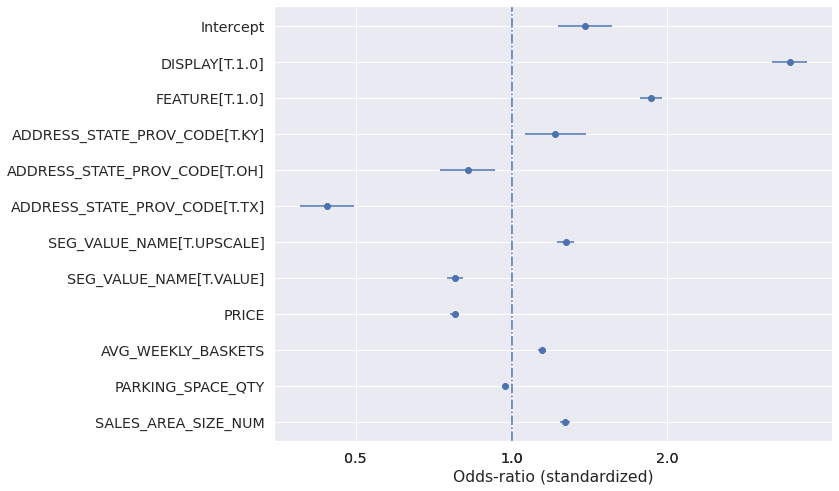

In [376]:
## check the odds ratio plot
fig = rsm.or_plot(reg_model, intercept = True)
fig = fig.set_xlabel("Odds-ratio (standardized)")

In [377]:
## Check the or_ci table and sort by 'importance'
or_df = rsm.or_ci(reg_model, intercept = True, importance = True).sort_values("importance", ascending = False)
or_df

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance
1,DISPLAY[T.1.0],3.445,244.5%,3.191,3.720,< .001,***,True,3.445
5,ADDRESS_STATE_PROV_CODE[T.TX],0.440,-56.0%,0.390,0.497,< .001,***,True,2.273
2,FEATURE[T.1.0],1.861,86.1%,1.774,1.953,< .001,***,True,1.861
0,Intercept,1.386,38.6%,1.230,1.561,< .001,***,False,1.386
8,PRICE,0.777,-22.3%,0.762,0.792,< .001,***,False,1.288
7,SEG_VALUE_NAME[T.VALUE],0.778,-22.2%,0.751,0.807,< .001,***,True,1.285
6,SEG_VALUE_NAME[T.UPSCALE],1.271,27.1%,1.226,1.319,< .001,***,True,1.271
11,SALES_AREA_SIZE_NUM,1.267,26.7%,1.239,1.296,< .001,***,False,1.267
4,ADDRESS_STATE_PROV_CODE[T.OH],0.823,-17.7%,0.729,0.928,0.002,**,True,1.216
3,ADDRESS_STATE_PROV_CODE[T.KY],1.215,21.5%,1.063,1.390,0.004,**,True,1.215


Text(0, 0.5, 'feature')

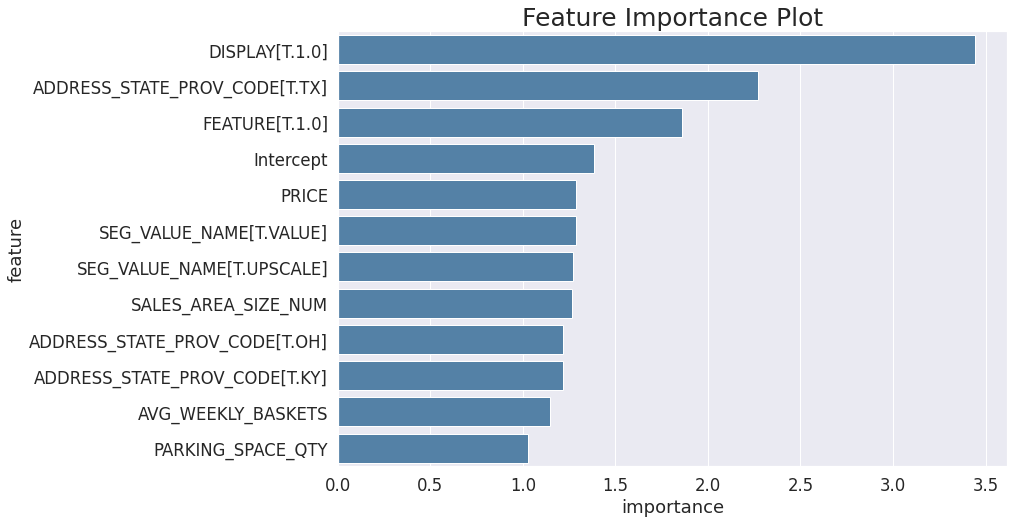

In [378]:
## plot the feature importance
plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.barplot(x="importance", y="index", data=or_df, color='steelblue')
plot.set_title("Feature Importance Plot", fontsize=25)
plot.set_ylabel("feature")

In [379]:
rsm.vif(reg)

,variable,vif,Rsq
0,ADDRESS_STATE_PROV_CODE[T.TX],20.527,0.951
1,ADDRESS_STATE_PROV_CODE[T.OH],19.666,0.949
2,ADDRESS_STATE_PROV_CODE[T.KY],5.038,0.801
3,SALES_AREA_SIZE_NUM,2.825,0.646
4,AVG_WEEKLY_BASKETS,2.178,0.541
5,PRICE,1.596,0.373
6,FEATURE[T.1.0],1.457,0.314
7,SEG_VALUE_NAME[T.VALUE],1.302,0.232
8,SEG_VALUE_NAME[T.UPSCALE],1.194,0.162
9,PARKING_SPACE_QTY,1.179,0.152


In [380]:
## Calculate RMSE for model performance on both training and testing dataset 

family_units_avg = df_family.UNITS.mean()
family_units_std = df_family.UNITS.std()
df_family_pred = df_family.copy()
df_family_scaled_pred = df_family_scaled.copy()
df_family_scaled_pred = df_family_scaled_pred.assign(pred_scaled = reg_model.predict(df_family_scaled_pred))
df_family_pred["pred"] = df_family_scaled_pred.pred_scaled * family_units_std + family_units_avg

test_pred = df_family_pred[df_family_pred.WEEK_END_DATE > '2010-12-31'].pred
y_test = df_family_pred[df_family_pred.WEEK_END_DATE > '2010-12-31'].UNITS

train_pred = df_family_pred[df_family_pred.WEEK_END_DATE <= '2010-12-31'].pred
y_train = df_family_pred[df_family_pred.WEEK_END_DATE <= '2010-12-31'].UNITS

print(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

16.79218431123609
20.527101530064662


In [382]:
## prediction by setting price

price = np.arange(2.5,5,0.01)
COGS_rate = 0.6
cost = df_family.PRICE.mean() * COGS_rate
family_units_avg = df_family.UNITS.mean()
family_units_std = df_family.UNITS.std()
price_avg = df_family.PRICE.mean()
price_std = df_family.PRICE.std() 

set_price = []
pred_sum_units = []
pred_sum_sales = []
pred_sum_profit = []

for p in price:
    df_family_pred = df_family.copy()
    df_family_pred["PRICE"] = p

    df_family_scaled_pred = df_family_scaled.copy()
    df_family_scaled_pred["PRICE"] = (p - price_avg) / price_std

    df_family_scaled_pred = df_family_scaled_pred.assign(pred_scaled = reg_model.predict(df_family_scaled_pred))
    df_family_pred["pred"] = df_family_scaled_pred.pred_scaled * family_units_std + family_units_avg
    
    units_sum = df_family_pred.pred.sum()
    sales_sum = (df_family_pred.pred * df_family_pred.PRICE).sum()
    profit_sum = ((df_family_pred.PRICE - cost) * df_family_pred.pred).sum()
    set_price.append(round(p,2))
    pred_sum_units.append(units_sum)
    pred_sum_sales.append(sales_sum)
    pred_sum_profit.append(profit_sum)
    
    #print("Predicted sum of units with price", round(p,1), "is:", units_sum)
    #print("Predicted sum of sales with price", round(p,1), "is:", sales_sum)
    #print("Predicted sum of profits with price", round(p,1), "is:", profit_sum)
    #print("--------------------")

Text(0.5, 1.0, 'Predicted Profits by Price')

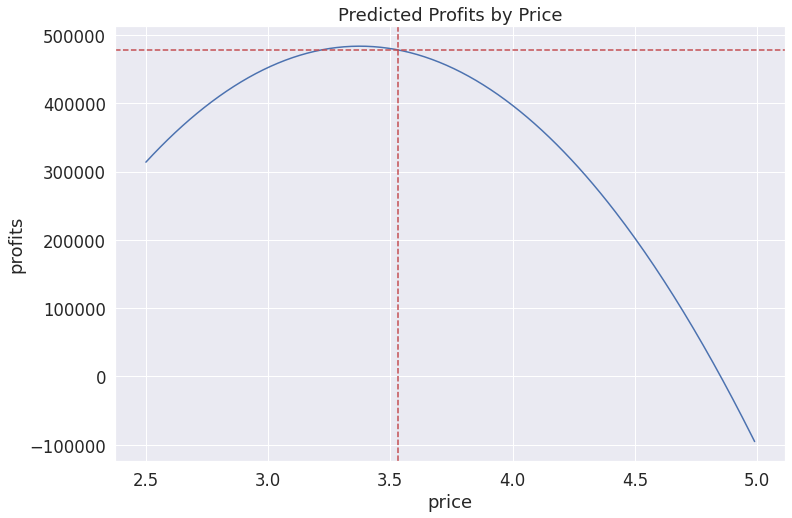

In [388]:
## predict the expected profit if setting price to $3.53
price_set = 3.53

result = {
    'price': set_price,
    'units': pred_sum_units,
    'sales': pred_sum_sales,
    'profits': pred_sum_profit
}

## convert dictionary to a data frame
df_result = pd.DataFrame.from_dict(result)
df_result

plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=df_result, x="price", y="profits")
plot.axhline(y = 478218, color = 'r', linestyle = '--')
plot.axvline(x = price_set, color = 'r', linestyle = '--')
plot.set_title('Predicted Profits by Price')

In [390]:
## make assumptions on cost
COGS_rate = 0.6

## compare the profit with the initial dataset without setting a price
orig_price = df_family.PRICE.mean()
orig_profits = ((df_family.PRICE - df_family.PRICE.mean() * COGS_rate) * df_family.UNITS).sum()
price_set = 3.53
exp_profits = round(float(df_result[df_result.price == price_set].profits), 2)
print("Original average family cereal price:", orig_price)
print("Original sum of family cereal profits:", orig_profits)
print("Set price at", price_set)
print("Expected Unites:", int(df_result[df_result.price == price_set].units))
print("Expected Sales:", round(float(df_result[df_result.price == price_set].sales), 2))
print("Expected Profits:", exp_profits)
print("------------------------------")
print("Increased total profits by", round(exp_profits - orig_profits, 2), ", which is a", round((exp_profits-orig_profits)/orig_profits * 100, 2), "% increase")

Original average family cereal price: 3.1643615591397847
Original sum of family cereal profits: 463596.4407137098
Set price at 3.53
Expected Unites: 293136
Expected Sales: 1034772.6
Expected Profits: 478218.27
------------------------------
Increased total profits by 14621.83 , which is a 3.15 % increase


In [392]:
## prediction by setting price and setting 'DISPLAY' to 1, and assume COGS_rate increase to 0.8 (more cost)

price = np.arange(2.5,5,0.01)
COGS_rate = 0.8
cost = df_family.PRICE.mean() * COGS_rate
family_units_avg = df_family.UNITS.mean()
family_units_std = df_family.UNITS.std()
price_avg = df_family.PRICE.mean()
price_std = df_family.PRICE.std() 

set_price = []
pred_sum_units = []
pred_sum_sales = []
pred_sum_profit = []

for p in price:
    df_family_pred = df_family.copy()
    df_family_pred["PRICE"] = p

    df_family_scaled_pred = df_family_scaled.copy()
    df_family_scaled_pred["PRICE"] = (p - price_avg) / price_std

    df_family_scaled_pred.DISPLAY = 1

    df_family_scaled_pred = df_family_scaled_pred.assign(pred_scaled = reg_model.predict(df_family_scaled_pred))
    df_family_pred["pred"] = df_family_scaled_pred.pred_scaled * family_units_std + family_units_avg
    
    units_sum = df_family_pred.pred.sum()
    sales_sum = (df_family_pred.pred * df_family_pred.PRICE).sum()
    profit_sum = ((df_family_pred.PRICE - cost) * df_family_pred.pred).sum()
    set_price.append(round(p,2))
    pred_sum_units.append(units_sum)
    pred_sum_sales.append(sales_sum)
    pred_sum_profit.append(profit_sum)
    

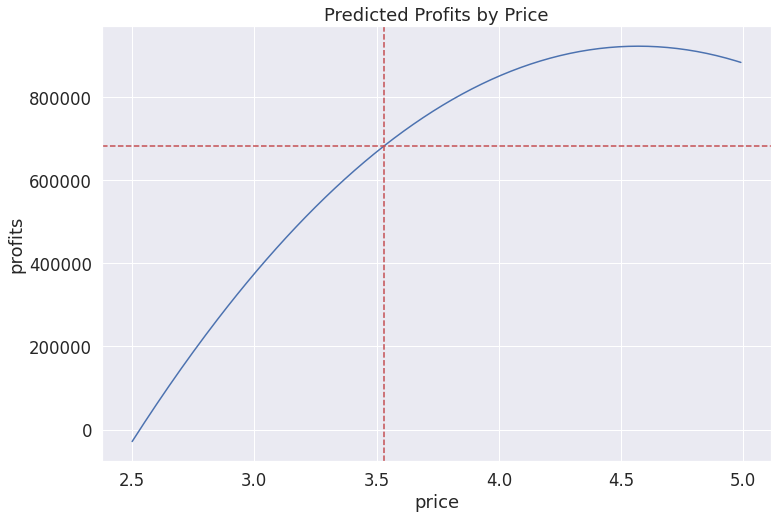

In [395]:
result = {
    'price': set_price,
    'units': pred_sum_units,
    'sales': pred_sum_sales,
    'profits': pred_sum_profit
}

## convert dictionary to a data frame
df_result = pd.DataFrame.from_dict(result)
df_result

plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=df_result, x="price", y="profits")
plot.set_title('Predicted Profits by Price')
plot.axhline(y = 682317.58, color = 'r', linestyle = '--')
plot.axvline(x = 3.53, color = 'r', linestyle = '--')
plt.ticklabel_format(style='plain')

In [394]:
## calculate the profit improvement after setting 'DISPLAY' to 1
COGS_rate = 0.6
orig_price = df_family.PRICE.mean()
orig_profits = ((df_family.PRICE - df_family.PRICE.mean() * COGS_rate) * df_family.UNITS).sum()
price_set = 3.53
exp_profits = round(float(df_result[df_result.price == price_set].profits), 2)
print("Original average family cereal price:", orig_price)
print("Original sum of family cereal profits:", orig_profits)
print("Set price at", price_set)
print("Expected Units:", int(df_result[df_result.price == price_set].units))
print("Expected Sales:", round(float(df_result[df_result.price == price_set].sales), 2))
print("Expected Profits:", exp_profits)
print("------------------------------")
print("Increased total profits by", round(exp_profits - orig_profits, 2), ", which is a", round((exp_profits-orig_profits)/orig_profits * 100, 2), "% increase")

Original average family cereal price: 3.1643615591397847
Original sum of family cereal profits: 463596.4407137098
Set price at 3.53
Expected Units: 683335
Expected Sales: 2412173.37
Expected Profits: 682317.58
------------------------------
Increased total profits by 218721.14 , which is a 47.18 % increase


### Regression Model_Kids Cereal

In [333]:
## split data into train and test
rvar = "UNITS"
evar = ['PRICE', 'DISPLAY', 'FEATURE', 'ADDRESS_STATE_PROV_CODE', 'AVG_WEEKLY_BASKETS', 'SEG_VALUE_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']

X = df_kids_scaled[evar].copy()
y = df_kids_scaled[rvar]

X_train = X[df_kids_scaled.WEEK_END_DATE <= '2010-12-31']
y_train = df_kids_scaled.loc[df_kids_scaled.WEEK_END_DATE <= '2010-12-31', 'UNITS']
X_test = X[df_kids_scaled.WEEK_END_DATE > '2010-12-31']
y_test = df_kids_scaled.loc[df_kids_scaled.WEEK_END_DATE > '2010-12-31', 'UNITS']

In [334]:
## Create regression model using training dataset
reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + ADDRESS_STATE_PROV_CODE +AVG_WEEKLY_BASKETS + SEG_VALUE_NAME + PARKING_SPACE_QTY + SALES_AREA_SIZE_NUM', 
              data = df_kids_scaled.query("WEEK_END_DATE <= '2010-12-31'"))
reg_model = reg.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  UNITS   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     1671.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:53:57   Log-Likelihood:                -15922.
No. Observations:               15773   AIC:                         3.187e+04
Df Residuals:                   15761   BIC:                         3.196e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

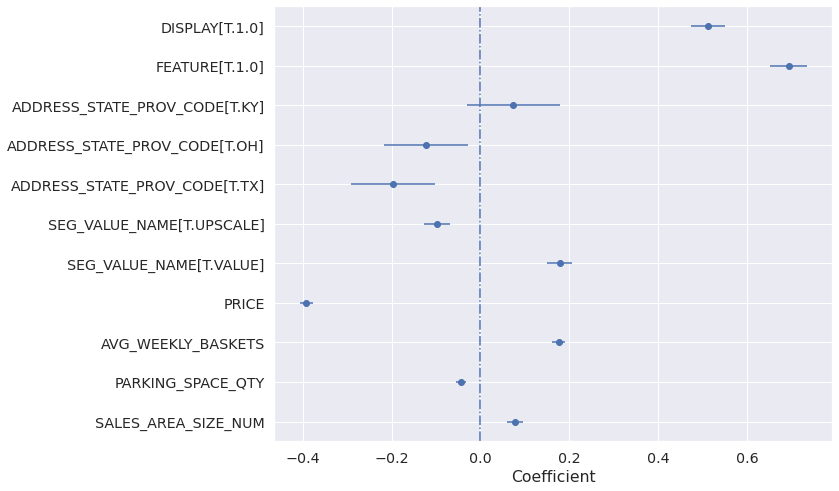

In [335]:
plt.rcParams["figure.figsize"] = [10,8]
sns.set(font_scale=1.3)
fig = rsm.coef_plot(reg_model)

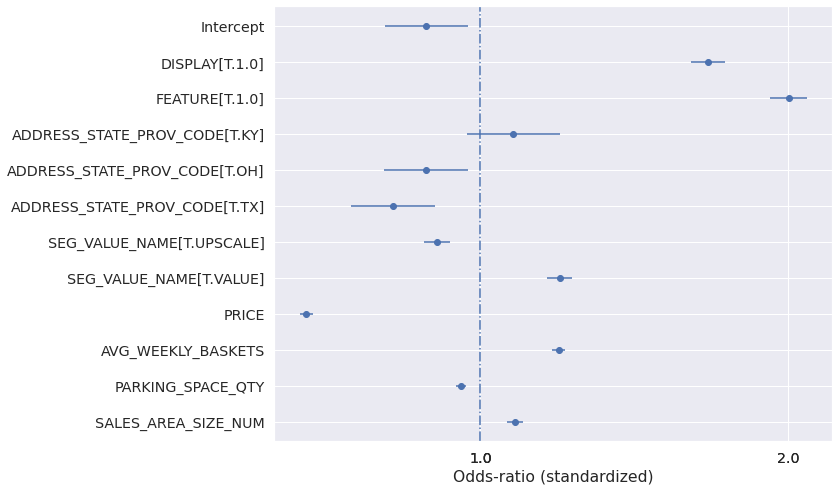

In [336]:
## plot the odds ratio
fig = rsm.or_plot(reg_model, intercept = True)
fig = fig.set_xlabel("Odds-ratio (standardized)")

In [337]:
## Check the or_ci table and sort by 'importance'
or_df = rsm.or_ci(reg_model, intercept = True, importance = True).sort_values("importance", ascending = False)
or_df

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance
2,FEATURE[T.1.0],2.001,100.1%,1.921,2.085,< .001,***,True,2.001
1,DISPLAY[T.1.0],1.668,66.8%,1.605,1.735,< .001,***,True,1.668
8,PRICE,0.676,-32.4%,0.666,0.686,< .001,***,False,1.480
5,ADDRESS_STATE_PROV_CODE[T.TX],0.822,-17.8%,0.748,0.903,< .001,***,True,1.217
7,SEG_VALUE_NAME[T.VALUE],1.195,19.5%,1.163,1.229,< .001,***,True,1.195
9,AVG_WEEKLY_BASKETS,1.192,19.2%,1.174,1.211,< .001,***,False,1.192
0,Intercept,0.885,-11.5%,0.806,0.972,0.01,*,False,1.130
4,ADDRESS_STATE_PROV_CODE[T.OH],0.885,-11.5%,0.805,0.972,0.011,*,True,1.130
6,SEG_VALUE_NAME[T.UPSCALE],0.907,-9.3%,0.881,0.933,< .001,***,True,1.103
11,SALES_AREA_SIZE_NUM,1.081,8.1%,1.062,1.100,< .001,***,False,1.081


Text(0, 0.5, 'feature')

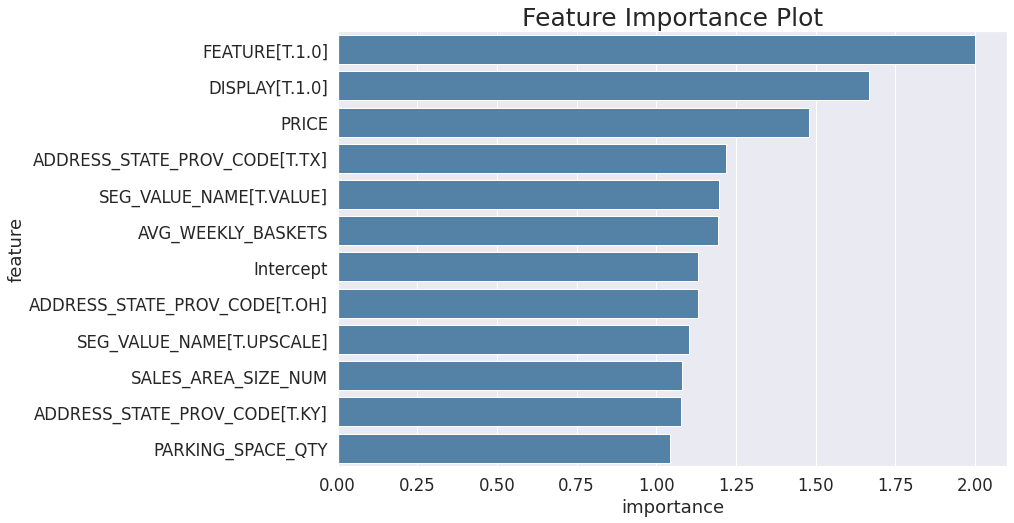

In [338]:
## plot the feature importance
plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.barplot(x="importance", y="index", data=or_df, color='steelblue')
plot.set_title("Feature Importance Plot", fontsize=25)
plot.set_ylabel("feature")

In [339]:
rsm.vif(reg)

,variable,vif,Rsq
0,ADDRESS_STATE_PROV_CODE[T.TX],20.633,0.952
1,ADDRESS_STATE_PROV_CODE[T.OH],19.966,0.950
2,ADDRESS_STATE_PROV_CODE[T.KY],5.034,0.801
3,SALES_AREA_SIZE_NUM,2.873,0.652
4,AVG_WEEKLY_BASKETS,2.190,0.543
5,FEATURE[T.1.0],1.914,0.478
6,PRICE,1.870,0.465
7,DISPLAY[T.1.0],1.718,0.418
8,SEG_VALUE_NAME[T.VALUE],1.338,0.253
9,SEG_VALUE_NAME[T.UPSCALE],1.191,0.160


In [340]:
## Calculate RMSE for model performance on both training and testing dataset 

kids_units_avg = df_kids.UNITS.mean()
kids_units_std = df_kids.UNITS.std()
df_kids_pred = df_kids.copy()
df_kids_scaled_pred = df_kids_scaled.copy()
df_kids_scaled_pred = df_kids_scaled_pred.assign(pred_scaled = reg_model.predict(df_kids_scaled_pred))
df_kids_pred["pred"] = df_kids_scaled_pred.pred_scaled * kids_units_std + kids_units_avg

test_pred = df_kids_pred[df_kids_pred.WEEK_END_DATE > '2010-12-31'].pred
y_test = df_kids_pred[df_kids_pred.WEEK_END_DATE > '2010-12-31'].UNITS

train_pred = df_kids_pred[df_kids_pred.WEEK_END_DATE <= '2010-12-31'].pred
y_train = df_kids_pred[df_kids_pred.WEEK_END_DATE <= '2010-12-31'].UNITS

print(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
print(np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

37.1643524377042
39.57866735358252


In [358]:
## prediction by setting price

price = np.arange(2,4,0.01)
COGS_rate = 0.6
cost = df_kids.PRICE.mean() * COGS_rate
kids_units_avg = df_kids.UNITS.mean()
kids_units_std = df_kids.UNITS.std()
price_avg = df_kids.PRICE.mean()
price_std = df_kids.PRICE.std() 

set_price = []
pred_sum_units = []
pred_sum_sales = []
pred_sum_profit = []

for p in price:
    df_kids_pred = df_kids.copy()
    df_kids_pred["PRICE"] = p

    df_kids_scaled_pred = df_kids_scaled.copy()
    df_kids_scaled_pred["PRICE"] = (p - price_avg) / price_std

    df_kids_scaled_pred = df_kids_scaled_pred.assign(pred_scaled = reg_model.predict(df_kids_scaled_pred))
    df_kids_pred["pred"] = df_kids_scaled_pred.pred_scaled * kids_units_std + kids_units_avg
    
    units_sum = df_kids_pred.pred.sum()
    sales_sum = (df_kids_pred.pred * df_kids_pred.PRICE).sum()
    profit_sum = ((df_kids_pred.PRICE - cost) * df_kids_pred.pred).sum()
    set_price.append(round(p,2))
    pred_sum_units.append(units_sum)
    pred_sum_sales.append(sales_sum)
    pred_sum_profit.append(profit_sum)
    
    #print("Predicted sum of units with price", round(p,1), "is:", units_sum)
    #print("Predicted sum of sales with price", round(p,1), "is:", sales_sum)
    #print("Predicted sum of profits with price", round(p,1), "is:", profit_sum)
    #print("--------------------")

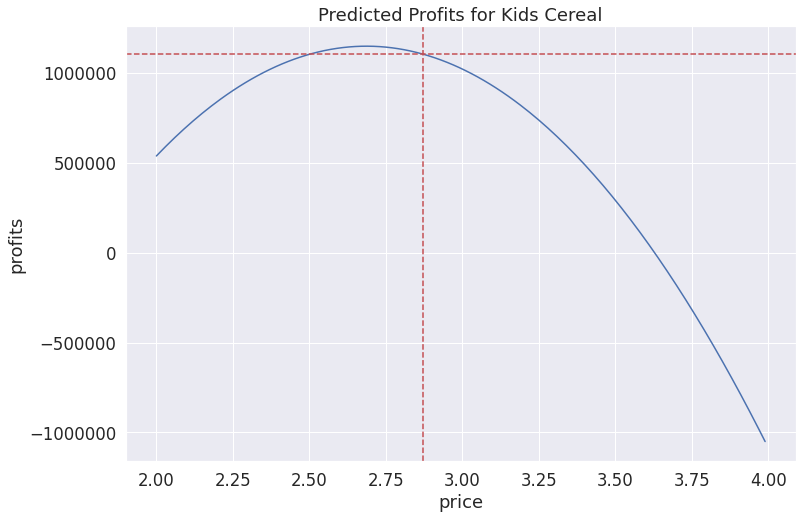

In [359]:
# predict the profit by setting price to $2.87
result = {
    'price': set_price,
    'units': pred_sum_units,
    'sales': pred_sum_sales,
    'profits': pred_sum_profit
}

# convert dictionary to a data frame
df_result = pd.DataFrame.from_dict(result)

plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=df_result, x="price", y="profits")
plot.set_title('Predicted Profits for Kids Cereal')
plot.axhline(y = 1103969.97, color = 'r', linestyle = '--')
plot.axvline(x = 2.87, color = 'r', linestyle = '--')
plt.ticklabel_format(style='plain')

In [361]:
## make assumptions on cost
COGS_rate = 0.6
orig_price = df_kids.PRICE.mean()
orig_profits = ((df_kids.PRICE - df_kids.PRICE.mean() * COGS_rate) * df_kids.UNITS).sum()

## compare the profit with the initial dataset without setting a price
price_set = 2.87
exp_profits = float(df_result[df_result.price == price_set].profits)
print("Original average family cereal price:", orig_price)
print("Original sum of family cereal profits:", orig_profits)
print("Set price at", price_set)
print("Expected Unites:", int(df_result[df_result.price == price_set].units))
print("Expected Sales:", round(float(df_result[df_result.price == price_set].sales), 2))
print("Expected Profits:", exp_profits)
print("------------------------------")
print("Increased total profits by", round(exp_profits - orig_profits, 2), ", which is a", round((exp_profits-orig_profits)/orig_profits * 100, 2), "% increase")

Original average family cereal price: 2.9085285021731866
Original sum of family cereal profits: 847032.5908497991
Set price at 2.87
Expected Unites: 981408
Expected Sales: 2816643.25
Expected Profits: 1103969.9731158828
------------------------------
Increased total profits by 256937.38 , which is a 30.33 % increase


In [369]:
## prediction by setting price and setting 'FEATURE' to 1, and assume COGS_rate increase to 0.8 (more cost)

price = np.arange(2,4,0.01)
COGS_rate = 0.8
cost = df_kids.PRICE.mean() * COGS_rate
kids_units_avg = df_kids.UNITS.mean()
kids_units_std = df_kids.UNITS.std()
price_avg = df_kids.PRICE.mean()
price_std = df_kids.PRICE.std() 

set_price = []
pred_sum_units = []
pred_sum_sales = []
pred_sum_profit = []

for p in price:
    df_kids_pred = df_kids.copy()
    df_kids_pred["PRICE"] = p

    df_kids_scaled_pred = df_kids_scaled.copy()
    df_kids_scaled_pred["PRICE"] = (p - price_avg) / price_std
    
    df_kids_scaled_pred.FEATURE = 1

    df_kids_scaled_pred = df_kids_scaled_pred.assign(pred_scaled = reg_model.predict(df_kids_scaled_pred))
    df_kids_pred["pred"] = df_kids_scaled_pred.pred_scaled * kids_units_std + kids_units_avg
    
    units_sum = df_kids_pred.pred.sum()
    sales_sum = (df_kids_pred.pred * df_kids_pred.PRICE).sum()
    profit_sum = ((df_kids_pred.PRICE - cost) * df_kids_pred.pred).sum()
    set_price.append(round(p,2))
    pred_sum_units.append(units_sum)
    pred_sum_sales.append(sales_sum)
    pred_sum_profit.append(profit_sum)

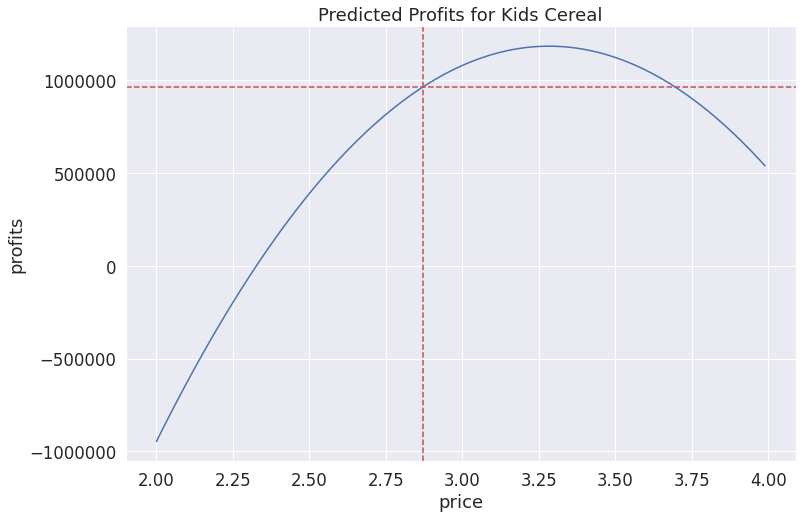

In [372]:
result = {
    'price': set_price,
    'units': pred_sum_units,
    'sales': pred_sum_sales,
    'profits': pred_sum_profit
}

## convert dictionary to a data frame
df_result = pd.DataFrame.from_dict(result)

plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=df_result, x="price", y="profits", ci = False)
plot.set_title('Predicted Profits for Kids Cereal')
plot.axhline(y = 963187, color = 'r', linestyle = '--')
plot.axvline(x = 2.87, color = 'r', linestyle = '--')
plt.ticklabel_format(style='plain')

In [371]:
## calculate the profit improvement after setting 'DISPLAY' to 1
COGS_rate = 0.6
orig_price = df_kids.PRICE.mean()
orig_profits = ((df_kids.PRICE - df_kids.PRICE.mean() * COGS_rate) * df_kids.UNITS).sum()
price_set = 2.87
exp_profits = float(df_result[df_result.price == price_set].profits)
print("Original average family cereal price:", orig_price)
print("Original sum of family cereal profits:", orig_profits)
print("Set price at", price_set)
print("Expected Unites:", int(df_result[df_result.price == price_set].units))
print("Expected Sales:", round(float(df_result[df_result.price == price_set].sales), 2))
print("Expected Profits:", exp_profits)
print("------------------------------")
print("Increased total profits by", round(exp_profits - orig_profits, 2), ", which is a", round((exp_profits-orig_profits)/orig_profits * 100, 2), "% increase")

Original average family cereal price: 2.9085285021731866
Original sum of family cereal profits: 847032.5908497991
Set price at 2.87
Expected Unites: 1773247
Expected Sales: 5089219.59
Expected Profits: 963187.4695472497
------------------------------
Increased total profits by 116154.88 , which is a 13.71 % increase
